# Refactored

In [22]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [23]:

# --------------------------
# Maze Environment
# --------------------------
class Maze:
    def __init__(self, maze=None, start=(0, 0), terminal=None):
        self.maze = maze if maze is not None else [
            [0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0],
            [0, 0, 0, 1, 0],
            [1, 1, 0, 0, 0],
            [0, 0, 0, 1, 2]
        ]
        self.start = start
        self.terminal = terminal if terminal else (len(self.maze)-1, len(self.maze[0])-1)
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
        self.action_names = ["up", "down", "left", "right"]
        self.rewards = {"step": -1, "invalid": -2, "terminal": 100}
        self.state = self.start

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action_idx):
        move = self.actions[action_idx]
        next_state = (self.state[0] + move[0], self.state[1] + move[1])

        if not (0 <= next_state[0] < len(self.maze) and
                0 <= next_state[1] < len(self.maze[0])) or \
                self.maze[next_state[0]][next_state[1]] == 1:
            reward, done = self.rewards["invalid"], False
            next_state = self.state
        elif next_state == self.terminal:
            reward, done = self.rewards["terminal"], True
        else:
            reward, done = self.rewards["step"], False

        self.state = next_state
        return next_state, reward, done

In [43]:
# --------------------------
# Q-Learning Agent
# --------------------------
class QAgent:
    def __init__(self, env, gamma=0.9, alpha=0.1, epsilon=1.0, epsilon_min=0.05, epsilon_decay=0.99):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.q_table = np.zeros((len(env.maze), len(env.maze[0]), len(env.actions)))

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, len(self.env.actions)-1)
        x, y = state
        q_values = self.q_table[x, y]
        max_q = np.max(q_values)
        best_actions = np.flatnonzero(q_values == max_q)
        return np.random.choice(best_actions)

    def learn(self, state, action_idx, reward, next_state, done):
        x, y = state
        nx, ny = next_state
        target = reward + (0 if done else self.gamma * np.max(self.q_table[nx, ny]))
        self.q_table[x, y, action_idx] += self.alpha * (target - self.q_table[x, y, action_idx])

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


In [44]:
# --------------------------
# SARSA Agent
# --------------------------
class SARSAgent(QAgent):
    def learn_sarsa(self, state, action_idx, reward, next_state, next_action_idx, done):
        x, y = state
        nx, ny = next_state
        next_q = 0 if done else self.q_table[nx, ny, next_action_idx]
        self.q_table[x, y, action_idx] += self.alpha * (reward + self.gamma * next_q - self.q_table[x, y, action_idx])


In [45]:
# --------------------------
# Training Loop (generic)
# --------------------------
def train_agent(env, agent, episodes=300, use_sarsa=False):
    scores, steps_list = [], []

    for ep in range(episodes):
        state = env.reset()
        done = False
        total_reward, steps = 0, 0

        action = agent.choose_action(state) if use_sarsa else None

        max_steps = env.maze.shape[0] * env.maze.shape[1]  # e.g., 100x100 maze → max 10000 steps
        while not done: #and steps < max_steps:
            if use_sarsa:
                next_state, reward, done = env.step(action)
                next_action = agent.choose_action(next_state)
                agent.learn_sarsa(state, action, reward, next_state, next_action, done)
                state, action = next_state, next_action
            else:
                action = agent.choose_action(state)
                next_state, reward, done = env.step(action)
                agent.learn(state, action, reward, next_state, done)
                state = next_state

            total_reward += reward
            steps += 1

        agent.decay_epsilon()
        scores.append(total_reward)
        steps_list.append(steps)

    return scores, steps_list


In [ ]:
# --------------------------
# Visualization Utilities
# --------------------------
def show_path(env, agent):
    state = env.reset()
    path = [state]
    done = False

    while not done:
        action = np.argmax(agent.q_table[state[0], state[1]])
        state, _, done = env.step(action)
        path.append(state)
        if len(path) > 50:  # safety
            break

    maze_disp = np.array(env.maze, dtype=str)
    maze_disp[maze_disp=="0"] = "."
    maze_disp[maze_disp=="1"] = "#"
    maze_disp[maze_disp=="2"] = "G"
    maze_disp[env.start] = "S"
    for x, y in path:
        if (x, y) != env.start and (x, y) != env.terminal:
            maze_disp[x, y] = "*"

    for row in maze_disp:
        print(" ".join(row))

def plot_q_heatmap(env, agent):
    values = np.max(agent.q_table, axis=2)
    mask = np.array(env.maze) == 1
    values = np.ma.masked_array(values, mask=mask)

    plt.figure(figsize=(8, 8))
    cmap = plt.cm.coolwarm
    cmap.set_bad(color='black')

    # Scale based only on what is actually plotted
    vmin = values.min()
    vmax = values.max()

    im = plt.imshow(values, cmap=cmap, origin='upper', vmin=vmin, vmax=vmax)

    sx, sy = env.start
    tx, ty = env.terminal
    plt.scatter(sy, sx, marker='o', color='green', s=200, label='Start')
    plt.scatter(ty, tx, marker='X', color='red', s=200, label='Terminal')

    plt.colorbar(im, label="Max Q-value")
    plt.title("State Value Heatmap")
    plt.legend()
    plt.show()



def plot_steps(scores, title="Steps per Episode"):
    plt.plot(scores)
    plt.xlabel("Episodes")
    plt.ylabel("Steps to goal")
    plt.title(title)
    plt.show()

def plot_score(scores, title="Score per Episode"):
    plt.plot(scores)
    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.title(title)
    plt.show()

def plot_agent_path(env, agent, max_steps=100, title="Agent Path"):
    state = env.reset()
    path = [state]
    done = False
    steps = 0

    while not done and steps < max_steps:
        action = agent.choose_action(state)
        next_state, _, done = env.step(action)
        path.append(next_state)
        state = next_state
        steps += 1

    path = np.array(path)
    values = np.zeros_like(env.maze, dtype=float)
    mask = np.array(env.maze) == 1
    values = np.ma.masked_array(values, mask=mask)

    plt.figure(figsize=(8, 8))
    cmap = plt.cm.coolwarm
    cmap.set_bad(color='black')
    plt.imshow(values, cmap=cmap, origin='upper')

    sx, sy = env.start
    tx, ty = env.terminal
    plt.scatter(sy, sx, marker='o', color='green', s=200, label='Start')
    plt.scatter(ty, tx, marker='X', color='red', s=200, label='Terminal')
    plt.plot(path[:,1], path[:,0], marker='o', color='yellow', linewidth=2, markersize=6, label="Agent Path")
    plt.title(title)
    plt.legend()
    plt.show()

In [53]:
import numpy as np
import random
import matplotlib.pyplot as plt

def generate_dfs_maze(size=20, seed=None):
    """
    Generates a solvable DFS maze of given size.
    size should be odd (to have proper walls/corridors).
    """
    if size % 2 == 0:
        size += 1  # make odd
    
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Step 1: Initialize maze with all walls
    maze = np.ones((size, size), dtype=int)

    # Step 2: Pick start and mark as open
    start = (1, 1)
    maze[start] = 0

    # Stack for DFS
    stack = [start]
    directions = [(2,0), (-2,0), (0,2), (0,-2)]  # move 2 steps at a time

    # Step 3: DFS to carve paths
    while stack:
        x, y = stack[-1]
        neighbors = []
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 1 <= nx < size-1 and 1 <= ny < size-1 and maze[nx, ny] == 1:
                neighbors.append((nx, ny))
        if neighbors:
            nx, ny = random.choice(neighbors)
            # Remove wall between
            maze[(x+nx)//2, (y+ny)//2] = 0
            maze[nx, ny] = 0
            stack.append((nx, ny))
        else:
            stack.pop()

    # Step 4: Set terminal and ensure it has at least one open neighbor
    terminal = (size-2, size-2)
    maze[terminal] = 0
    tx, ty = terminal
    neighbors = [(tx-1, ty), (tx+1, ty), (tx, ty-1), (tx, ty+1)]
    for nx, ny in neighbors:
        if 0 <= nx < size and 0 <= ny < size:
            maze[nx, ny] = 0
            break
    maze[terminal] = 2  # mark terminal

    # Step 5: Ensure start has at least one open neighbor
    sx, sy = start
    neighbors = [(sx-1, sy), (sx+1, sy), (sx, sy-1), (sx, sy+1)]
    for nx, ny in neighbors:
        if 0 <= nx < size and 0 <= ny < size:
            maze[nx, ny] = 0
            break

    return maze, start, terminal


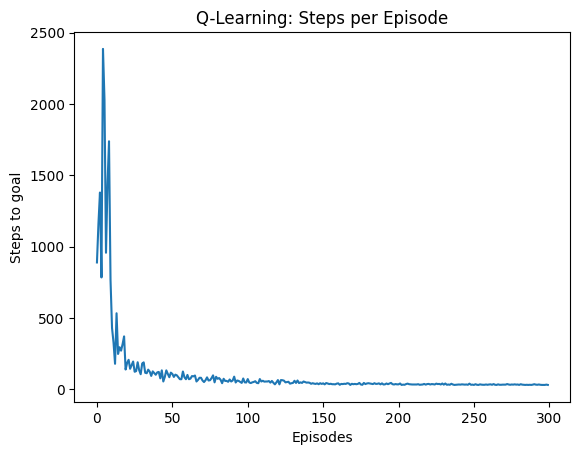

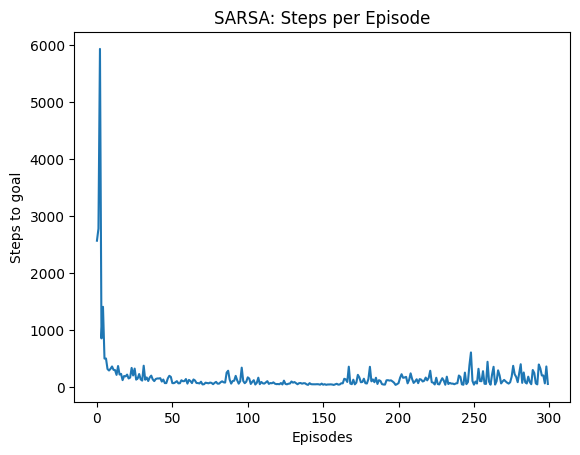

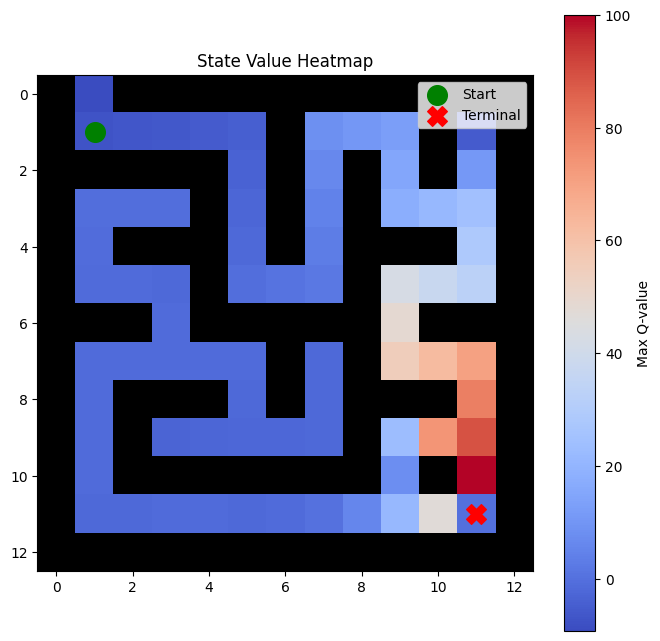

# . # # # # # # # # # # #
# S * * * * # * * * # . #
# # # # # * # * # * # . #
# . . . # * # * # * * * #
# . # # # * # * # # # * #
# . . . # * * * # * * * #
# # # . # # # # # * # # #
# . . . . . # . # * * * #
# . # # # . # . # # # * #
# . # . . . . . # . . * #
# . # # # # # # # . # * #
# . . . . . . . . . . G #
# # # # # # # # # # # # #


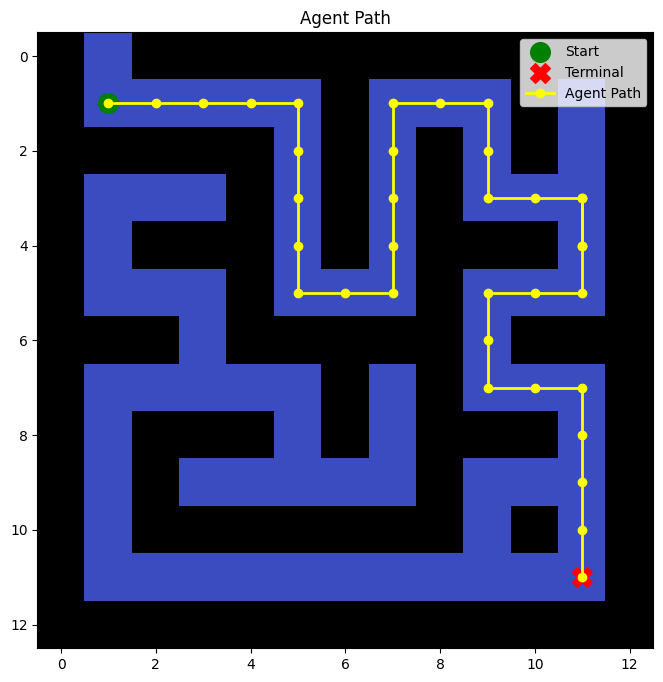

In [55]:
# --------------------------
# Example Usage
# --------------------------
maze, start, terminal = generate_dfs_maze(size=13)

env = Maze(maze, start=start, terminal=terminal)
q_agent = QAgent(env)
sarsa_agent = SARSAgent(env)

scores_q, steps_q = train_agent(env, q_agent, episodes=300)
scores_sarsa, steps_sarsa = train_agent(env, sarsa_agent, episodes=300, use_sarsa=True)

plot_steps(steps_q, "Q-Learning: Steps per Episode")
plot_steps(steps_sarsa, "SARSA: Steps per Episode")
plot_q_heatmap(env, q_agent)
show_path(env, q_agent)
plot_agent_path(env, q_agent)

In [64]:
# Break into chunks of 10
chunk_size = 10
rolling_avgs = [
    int(np.mean(scores_sarsa[i:i+chunk_size]))
    for i in range(0, len(scores_sarsa), chunk_size)
]

In [66]:
# Break into chunks of 10
chunk_size = 10
rolling_avgs_steps = [
    int(np.mean(steps_sarsa[i:i+chunk_size]))
    for i in range(0, len(steps_sarsa), chunk_size)
]